# 빅쿼리 연결

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
## 라이브러리 로드

# BigQuery
from google.cloud import bigquery

# viz libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.express as px

# viz settings
%matplotlib inline
sns.set()
init_notebook_mode(connected=True)

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 52.1 MB/s eta 0:00:00


In [ ]:
# Client 객체 생성
client = bigquery.Client(project = '755804531278')

# 데이터셋 참조경로(reference) 설정
# Kaggle커널에서는 bq_helper를 대신 사용할 수도 있다.
dataset_ref = client.dataset('google_analytics_sample', project='bigquery-public-data')

# 해당 경로로부터 데이터셋 추출
dataset = client.get_dataset(dataset_ref)

In [ ]:
# 데이터셋을 테이블 단위로 보기
tables = list(client.list_tables(dataset))
table_names = sorted([t.table_id for t in tables])

# 테이블 단위로 간단한 정보 확인
print(f"""table 개수 : {len(tables)}
tables : {", ".join(table_names[:3])}, ...
date 범위 : {table_names[0][-8:]} ~ {table_names[-1][-8:]}""")

table 개수 : 369
tables : Google-ecommerce-dataset-table, daily_total_visits, daily_visits, ...
date 범위 : et-table ~ 20170801


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
# 테이블 경로 생성
table_ref_temp = dataset_ref.table(table_names[0])

# 테이블 가져오기
table_temp = client.get_table(table_ref_temp)

# 컬럼 확인
client.list_rows(table_temp, max_results=5).to_dataframe()

""


#1. Acquisition 변수 탐색 및 시각화
- 특정 기간 동안의 세션 데이터에서 유입 경로 관련 필드를 추출하여 분석 지표 산출에 활용

In [ ]:
query = """
SELECT
  trafficSource.source,
  trafficSource.medium,
  trafficSource.campaign,
  trafficSource.keyword,
  trafficSource.adContent,
  channelGrouping,
  trafficSource.referralPath
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
"""

trafficSource_df = client.query(query).to_dataframe()
trafficSource_df

,source,medium,campaign,keyword,adContent,channelGrouping,referralPath
0,(not set),(not set),(not set),None,None,(Other),None
1,(not set),(not set),(not set),None,None,(Other),None
2,Partners,(not set),(not set),None,None,(Other),None
3,Partners,(not set),(not set),None,None,(Other),None
4,Partners,(not set),(not set),None,None,(Other),None
...,...,...,...,...,...,...,...
903648,reddit.com,referral,(not set),None,None,Social,/r/golang/comments/4jlqzs/purple_gophers_on_sale_595_each/
903649,youtube.com,referral,(not set),None,None,Social,/yt/about/sv/
903650,youtube.com,referral,(not set),None,None,Social,/yt/about/
903651,youtube.com,referral,(not set),None,None,Social,/yt/about/


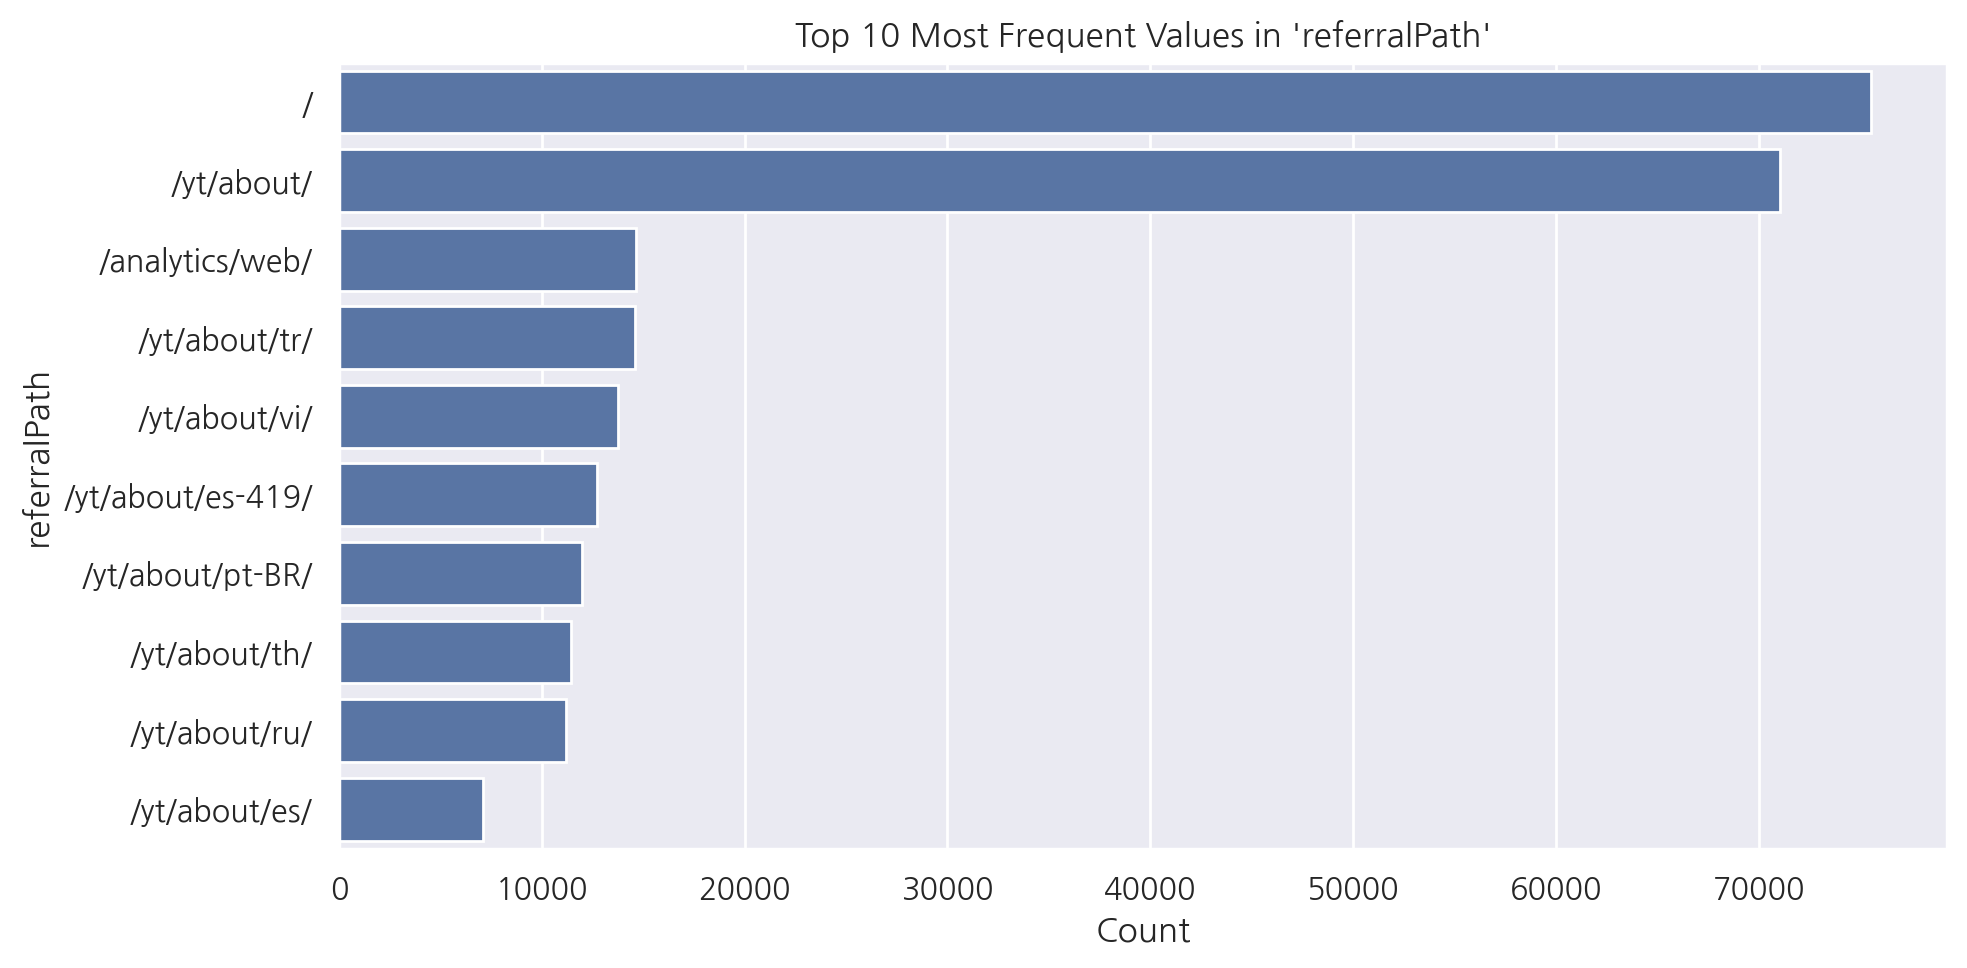

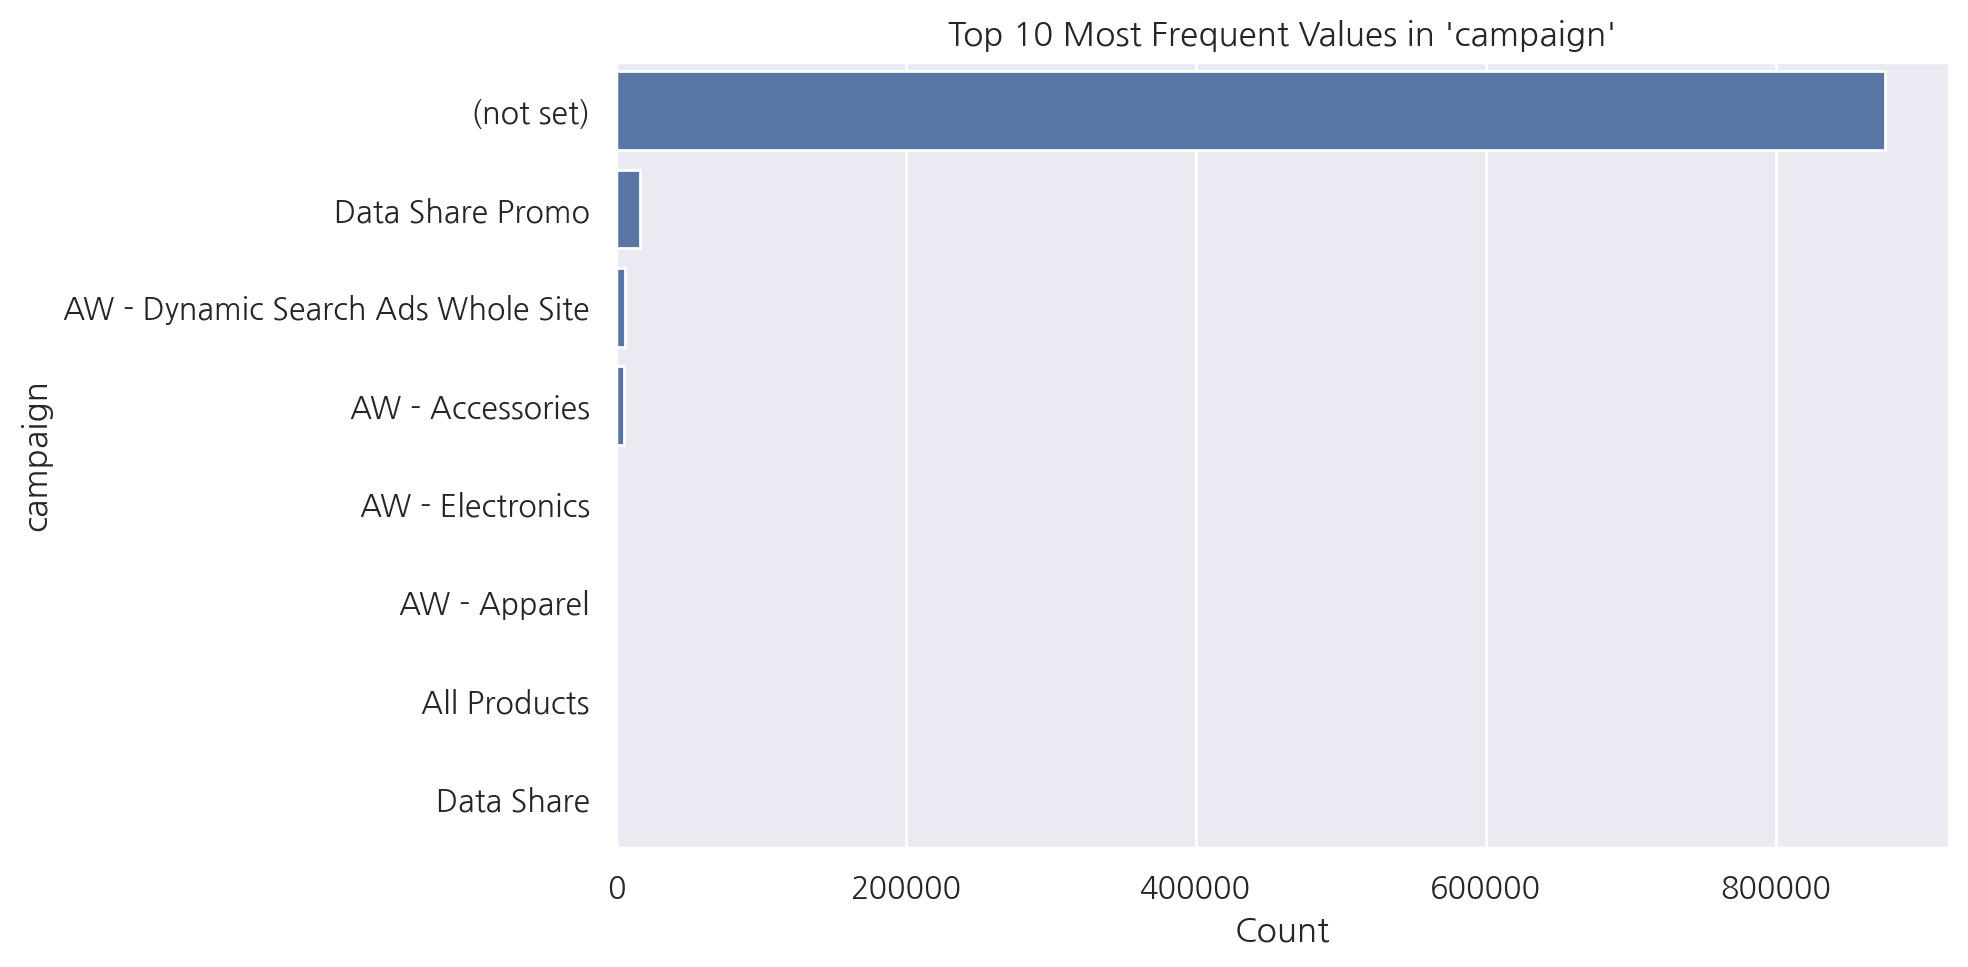

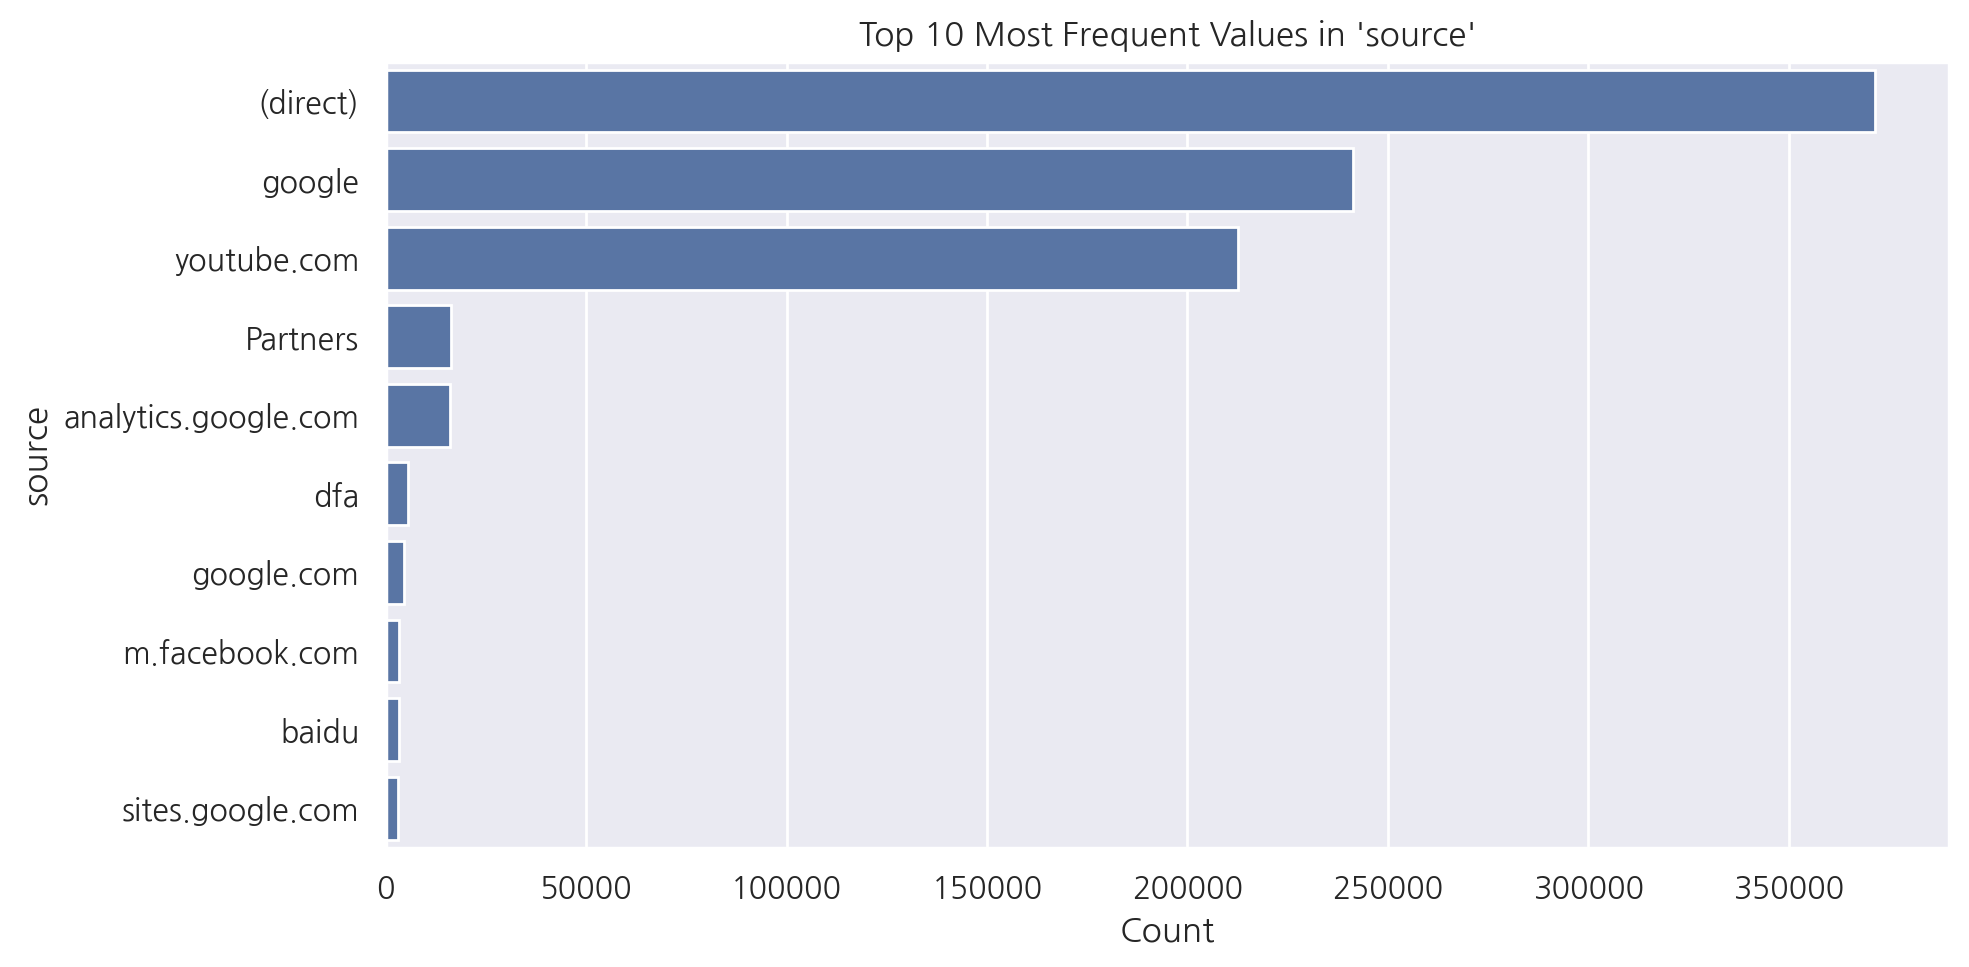

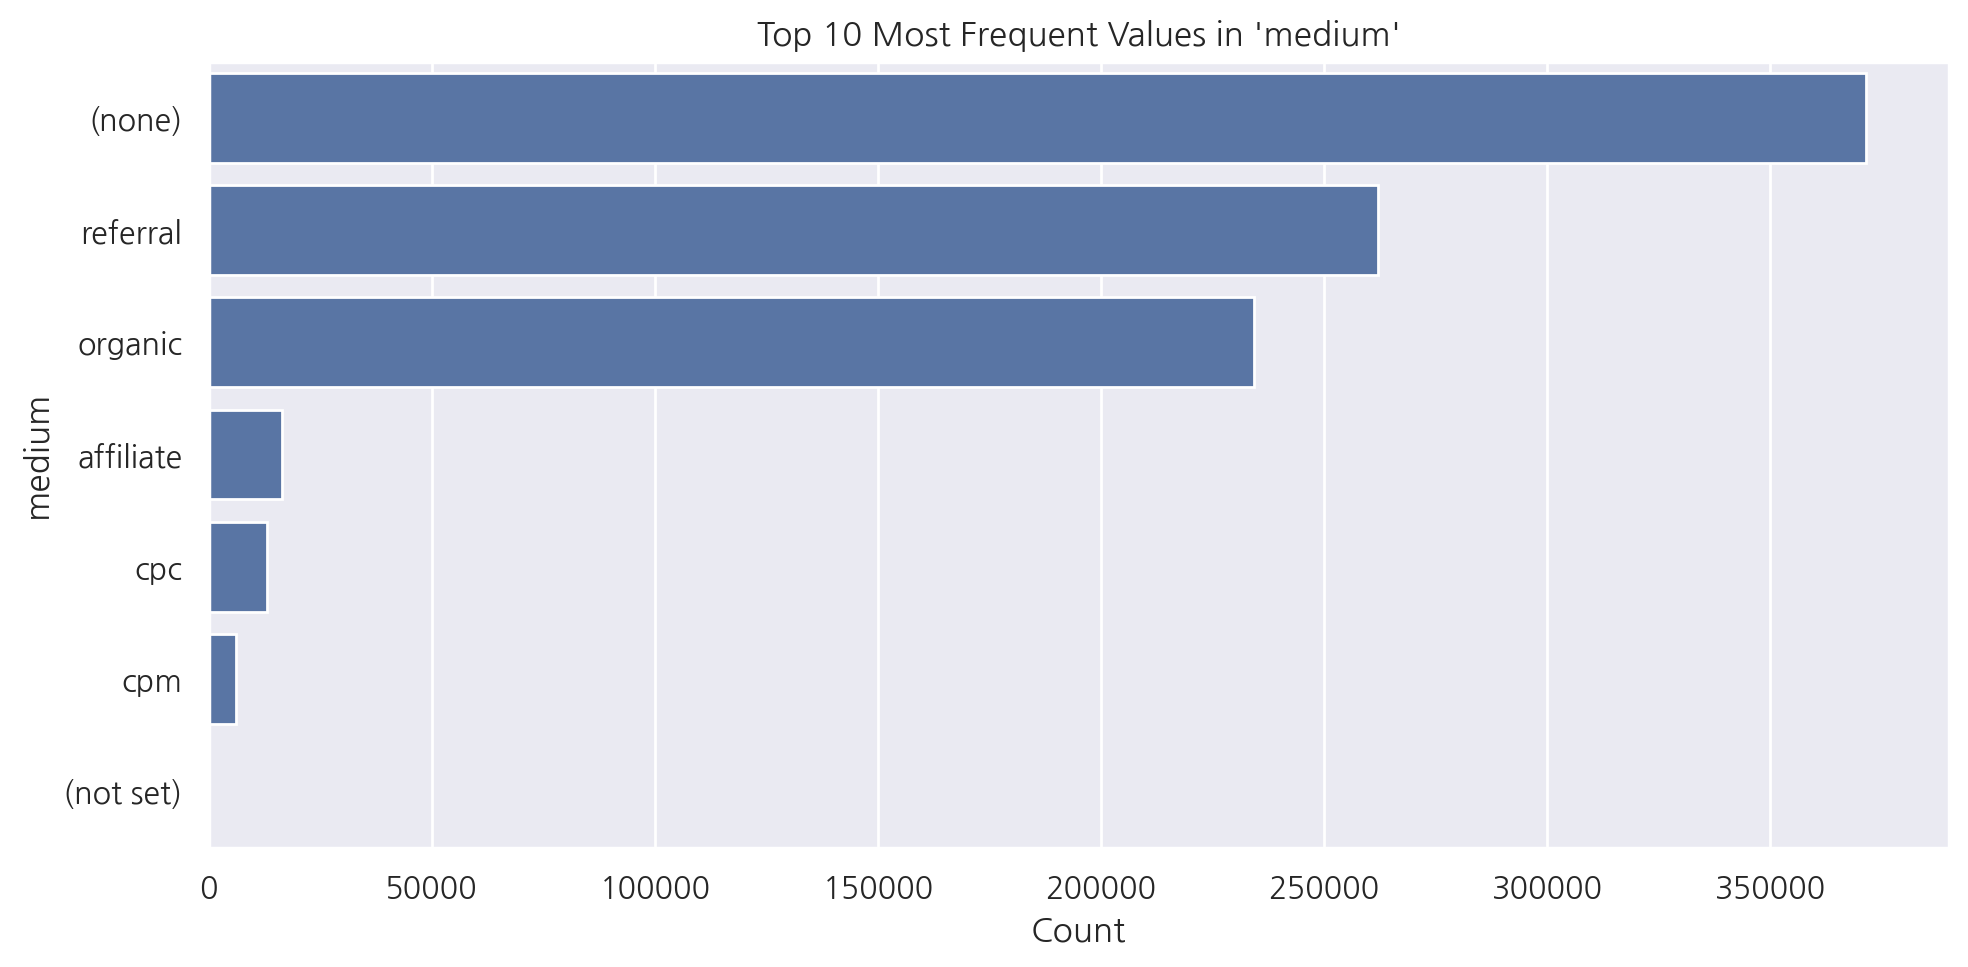

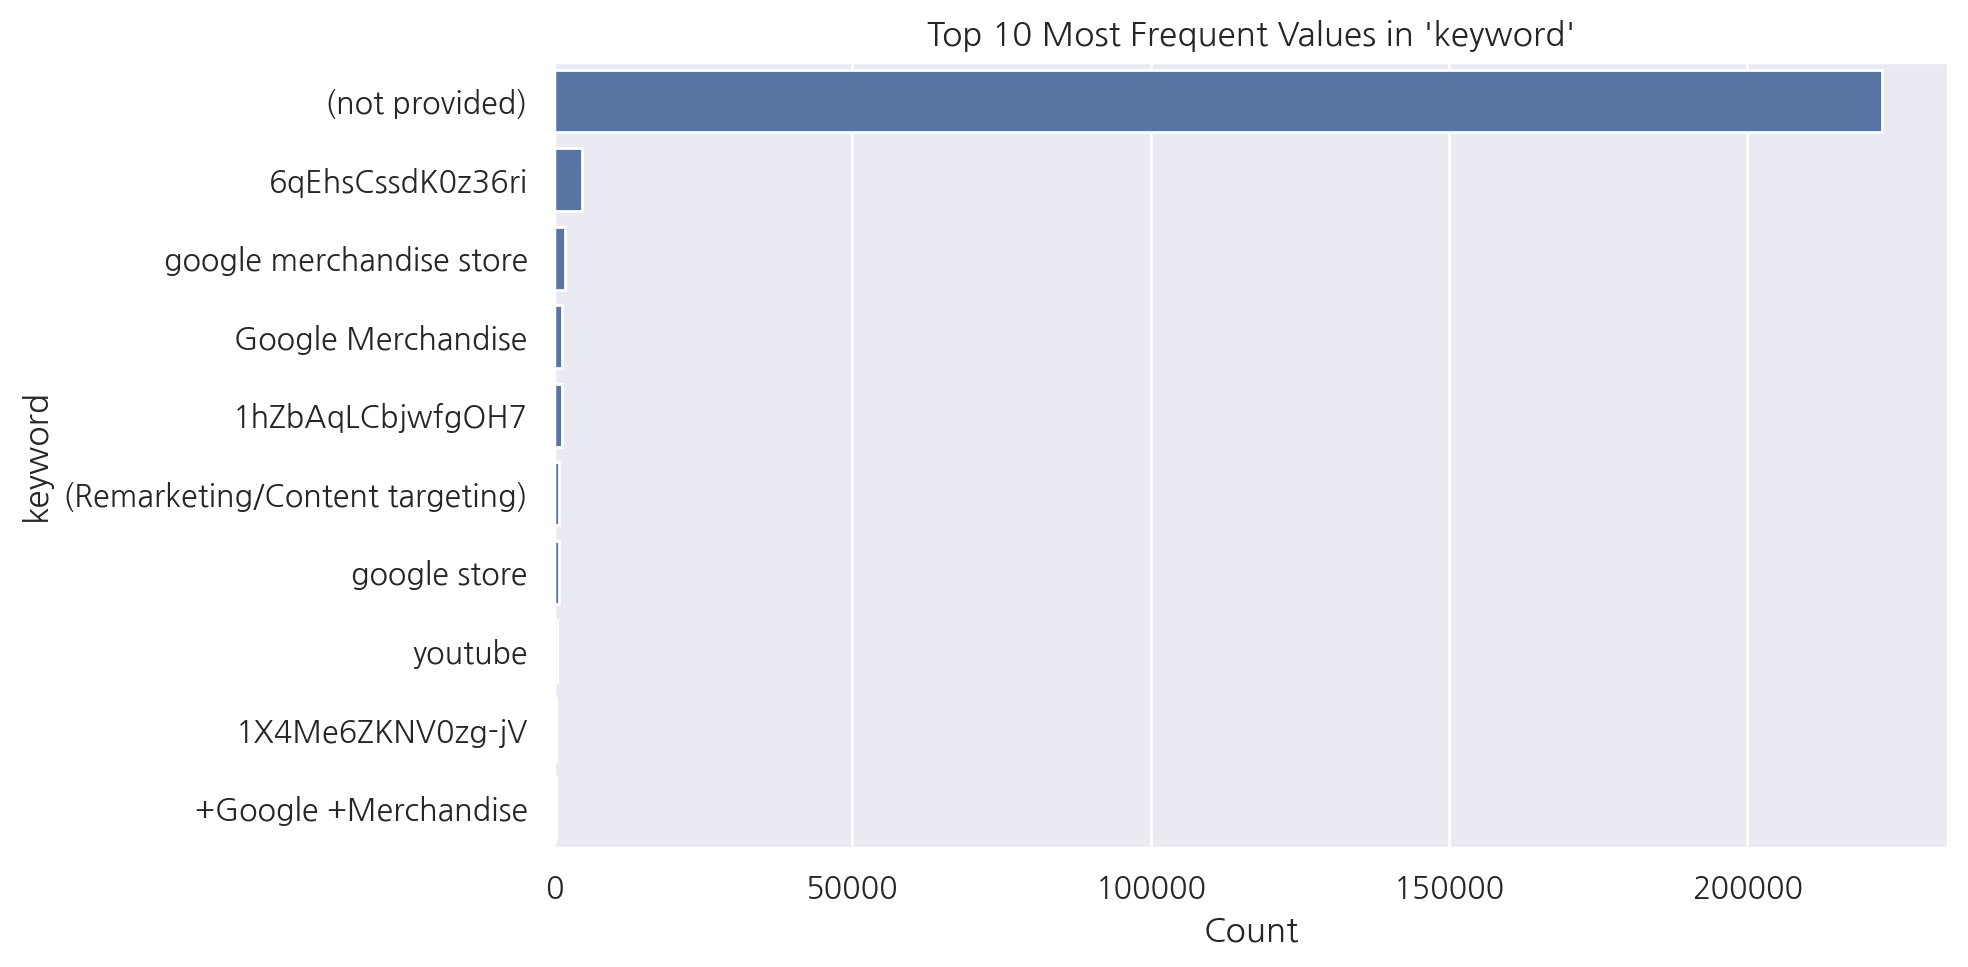

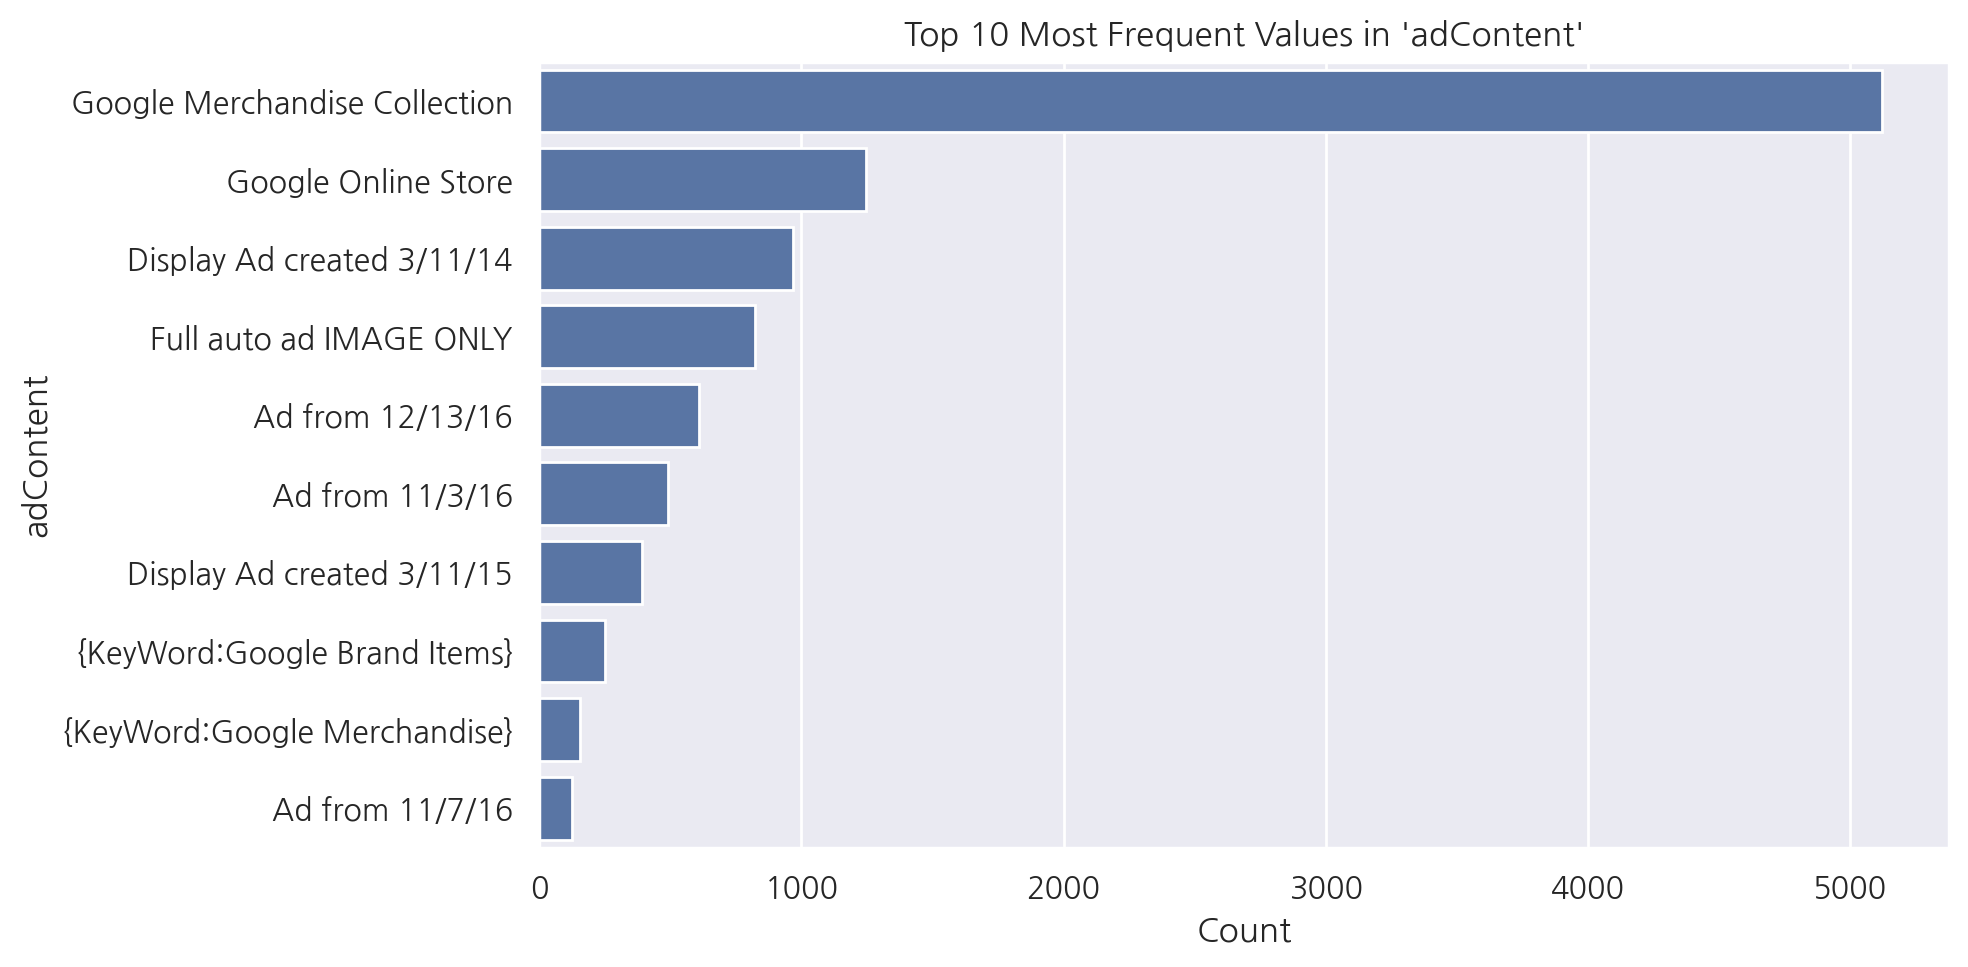

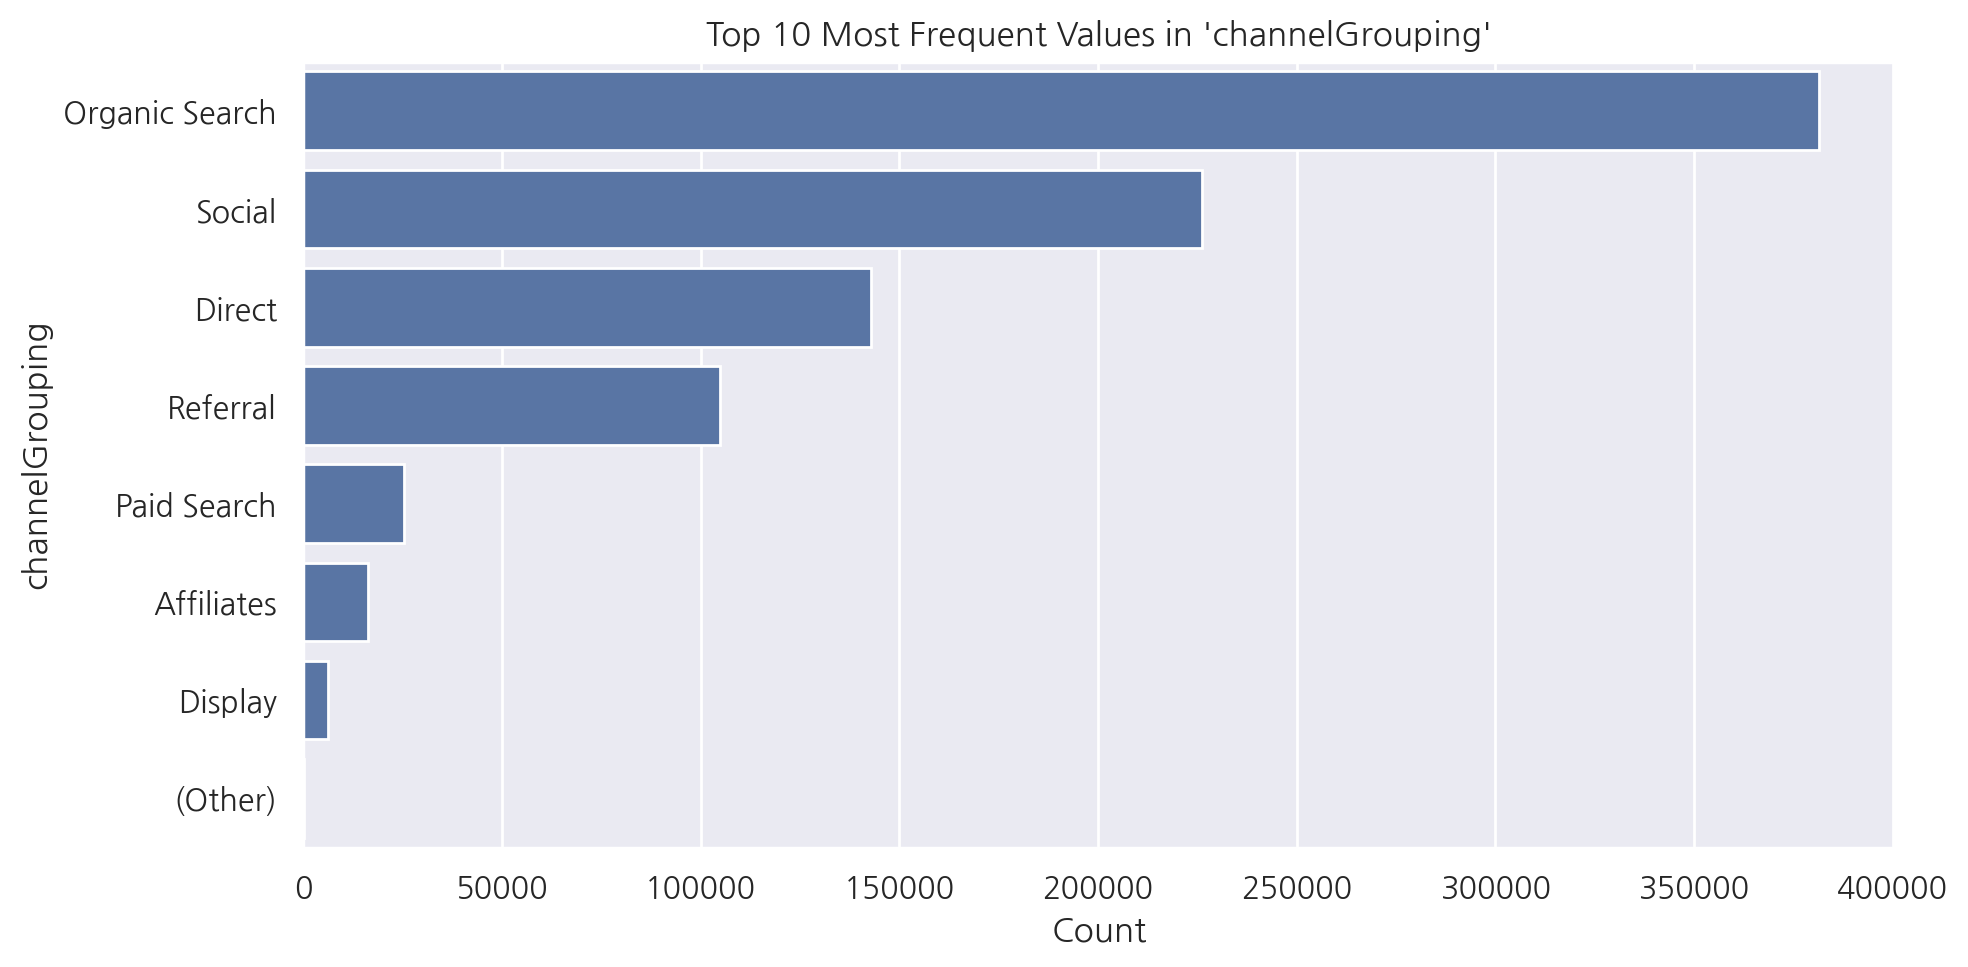

In [ ]:
# 변수별 value_counts() 결과 시각화
def plot_value_counts(trafficSource_df, column_name, top_n=10):
    plt.figure(figsize=(10, 5))
    counts = trafficSource_df[column_name].value_counts(dropna=True).head(top_n)
    sns.barplot(x=counts.values, y=counts.index)
    plt.title(f"Top {top_n} Most Frequent Values in '{column_name}'")
    plt.xlabel("Count")
    plt.ylabel(column_name)
    plt.tight_layout()
    plt.show()

cols_to_plot = [
    "referralPath",
    "campaign",
    "source",
    "medium",
    "keyword",
    "adContent",
    "channelGrouping",

]

for col in cols_to_plot:
    plot_value_counts(trafficSource_df, col, top_n=10)

# ２. ARPU / ARPPU 분석
- 총 매출을 전체 사용자 수와 구매 사용자 수로 나누어 각각 평균 매출 기여도를 평가하는 방법
- ARPU : 총매출 / 전체 고유 사용자 수
- ARPPU : 총매출 / 구매 사용자 수

In [ ]:
query = f"""
SELECT
  COUNT(DISTINCT fullVisitorId) AS total_users,
  COUNT(DISTINCT CASE WHEN totals.transactions IS NOT NULL THEN fullVisitorId END) AS purchasers,
  SUM(totals.totalTransactionRevenue)/1e6 AS total_revenue,
  SAFE_DIVIDE(SUM(totals.totalTransactionRevenue)/1e6, COUNT(DISTINCT fullVisitorId)) AS ARPU,
  SAFE_DIVIDE(SUM(totals.totalTransactionRevenue)/1e6, COUNT(DISTINCT CASE WHEN totals.transactions IS NOT NULL THEN fullVisitorId END)) AS ARPPU
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801';
"""
result = client.query(query).result().to_dataframe()
display(result.head())

,total_users,purchasers,total_revenue,ARPU,ARPPU
0,714167,10022,1780149.23,2.492623,177.62415


# 3. 고객별 누적 매출 분포 (Pareto)
- 구매 고객을 총매출 기준으로 5분위로 나누어 각 분위가 전체 매출에서 차지하는 비중을 확인
- revenue_by_user CTE
  - toals.totalTransactionRevenue를 합산해 사용자 단위 총매출을 계산
  - 구매가 한 번이라도 있었던 사용자만 포함
- ranked CTE
  - 사용자 총 매출을 내림차순 정렬 후 5분위 그룹을 부여
  - 각 사용자는 매출 수준에 따라 1~5 분위 중 하나에 속함
- 최종 SELECT
  - 분위별로 사용자 수, 분위별 매출 합, 전체 매출 대비 점유율 계산

In [ ]:
query = f"""
WITH revenue_by_user AS (
  SELECT
    fullVisitorId,
    SUM(totals.totalTransactionRevenue)/1e6 AS total_revenue
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND totals.totalTransactionRevenue IS NOT NULL
  GROUP BY
    fullVisitorId
),
ranked AS (
  SELECT *,
    NTILE(5) OVER (ORDER BY total_revenue DESC) AS quintile
  FROM revenue_by_user
)
SELECT
  quintile,
  COUNT(*) AS users,
  SUM(total_revenue) AS revenue,
  SAFE_DIVIDE(SUM(total_revenue), (SELECT SUM(total_revenue) FROM ranked)) AS revenue_share
FROM
  ranked
GROUP BY
  quintile
ORDER BY
  quintile;
"""
result = client.query(query).result().to_dataframe()
display(result.head(50))

,quintile,users,revenue,revenue_share
0,1,2000,1359823.77,0.763882
1,2,1999,203315.08,0.114212
2,3,1999,112153.43,0.063002
3,4,1999,68022.54,0.038212
4,5,1999,36834.41,0.020692


# 4. 브라우저·운영체제·기기별 Top 20 유입군 ARPU/전환율 분석
- 브라우저·운영체제·기기별 상위 20개 유입군의 사용자 수, 세션 수, 구매 성과와 매출 지표(ARPU, AOV, 전환율)를 집계

In [ ]:
query = f"""
-- 브라우저 / 운영체제 / 기기별 유입 Top 20 + 유입 대비 매출 지표
SELECT
  device.deviceCategory,
  device.operatingSystem,
  device.browser,

  -- 유입 규모
  COUNT(DISTINCT fullVisitorId) AS users,
  COUNT(*) AS sessions,

  -- 구매 관련
  COUNT(DISTINCT IF(totals.transactions > 0, fullVisitorId, NULL)) AS purchasers,
  SUM(IFNULL(totals.transactions, 0)) AS transactions,
  SUM(IFNULL(totals.totalTransactionRevenue, 0)) / 1000000.0 AS revenue_usd,

  -- 유입 대비 매출 지표
  SAFE_DIVIDE(
    SUM(IFNULL(totals.totalTransactionRevenue, 0)) / 1000000.0,
    COUNT(DISTINCT fullVisitorId)
  ) AS arpu_usd,  -- 1인당 매출

  SAFE_DIVIDE(
    SUM(IFNULL(totals.totalTransactionRevenue, 0)) / 1000000.0,
    NULLIF(SUM(IFNULL(totals.transactions, 0)), 0)
  ) AS aov_usd,   -- 평균 주문 금액(거래 1건당)

  SAFE_DIVIDE(
    COUNT(DISTINCT IF(totals.transactions > 0, fullVisitorId, NULL)),
    COUNT(DISTINCT fullVisitorId)
  ) AS user_conversion_rate -- 구매자 비중(유저 전환율)

FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY
  1, 2, 3
QUALIFY
  ROW_NUMBER() OVER (ORDER BY users DESC) <= 20  -- 유입(Users) 기준 Top 20
ORDER BY
  users DESC;
"""
result = client.query(query).result().to_dataframe()
display(result.head(20))

,deviceCategory,operatingSystem,browser,users,sessions,purchasers,transactions,revenue_usd,arpu_usd,aov_usd,user_conversion_rate
0,desktop,Windows,Chrome,235591,284523,1735,2221,375284.66,1.592950,168.971031,0.007364
1,desktop,Macintosh,Chrome,98127,156187,5203,6296,895331.92,9.124216,142.206468,0.053023
2,desktop,Macintosh,Safari,85709,92137,314,354,37059.12,0.432383,104.686780,0.003664
3,mobile,Android,Chrome,79921,101953,383,419,37713.83,0.471889,90.009141,0.004792
4,mobile,iOS,Safari,55806,71029,318,334,14505.39,0.259925,43.429311,0.005698
5,desktop,Windows,Firefox,24614,28346,110,151,139013.51,5.647742,920.619272,0.004469
6,desktop,Linux,Chrome,21719,30967,732,799,48772.81,2.245629,61.042315,0.033703
7,desktop,Chrome OS,Chrome,17455,26337,768,1033,196822.74,11.276009,190.535082,0.043999
8,desktop,Windows,Internet Explorer,16195,17802,81,97,8122.51,0.501544,83.737216,0.005002
9,tablet,iOS,Safari,14103,17446,97,98,5818.28,0.412556,59.370204,0.006878


# 5. 기기 유형별 Acquisition 품질 비교 (모바일 vs 데스크탑 vs 태블릿)
- 모바일,데스크탑,태블릿 사용자의 유입 후 제품 상세 조회 전환율을 비교해 채널별 초기 전환 성과를 평가하는 방법
- base CTE
  - 기간동안 방문한 모든 사용자와 디바이스 카테고리 추출
- activated CTE
  - 동일 기간의 세션에서 UNNEST(hits) 후 eCommerceAction.action_type = '2' (제품 상세 조회) 조건을 만족한 사용자만 추출
- 최종 SELECT
  - 디바이스별 activation 전환율을 비교

In [ ]:
query = f"""
SELECT DISTINCT device.deviceCategory
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _table_suffix between '20160801' and '20170801'
ORDER BY 1
"""
result = client.query(query).result().to_dataframe()
display(result)

,deviceCategory
0,desktop
1,mobile
2,tablet


In [ ]:
query = f"""
WITH base AS (
  SELECT
    device.deviceCategory,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
),
activated AS (
  SELECT DISTINCT fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
  WHERE
    _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
    AND hits.eCommerceAction.action_type = '2'
)
SELECT
  base.deviceCategory,
  COUNT(DISTINCT base.fullVisitorId) AS total_users,
  COUNT(DISTINCT activated.fullVisitorId) AS activated_users,
  SAFE_DIVIDE(COUNT(DISTINCT activated.fullVisitorId), COUNT(DISTINCT base.fullVisitorId)) * 100 AS activation_rate
FROM base
LEFT JOIN activated USING(fullVisitorId)
GROUP BY base.deviceCategory
ORDER BY total_users DESC
"""
result = client.query(query).result().to_dataframe()
display(result.head(10))

,deviceCategory,total_users,activated_users,activation_rate
0,desktop,523690,72927,13.925605
1,mobile,166173,23102,13.902379
2,tablet,24304,3227,13.277650


# 6. 국가별 Revenue Top 10 분석
- 매출이 발생하지 않은 국가는 제외하고 전체 매출 기여도가 어떤 국가에 집중되는지 확인

In [ ]:
## 국가별
query = f"""
SELECT
  geoNetwork.country,
  SUM(totals.totalTransactionRevenue)/1000000 AS lifetime_revenue_usd
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
GROUP BY geoNetwork.country
HAVING lifetime_revenue_usd IS NOT NULL
ORDER BY lifetime_revenue_usd DESC
"""
x = client.query(query).result().to_dataframe()
x.head(10)

,country,lifetime_revenue_usd
0,United States,1664260.72
1,Venezuela,36082.25
2,Canada,34921.89
3,Japan,7629.13
4,Kenya,5285.70
5,Nigeria,3314.40
6,Indonesia,2678.14
7,Taiwan,2015.89
8,United Kingdom,1962.36
9,Australia,1811.26


# 7. 제품별 Revenue 비교

#### (1) Repeat Purchase Rate (재구매율)
- 분석 기간 동안 최소 2회 이상 구매한 고객이 전체 구매 고객을 차지하는 비율 확인
- purchase_counts CTE
  - totals.transactions가 존재하는 경우만 추출하여 구매 세션으로 정의
  - 사용자별로 구매 세션 수를 집계해 purchase_count 생성
  - 각 사용자가 해당 기간 동안 몇 번 구매했는지 알 수 있음
- 최종 SELECT
  - 구매 횟수가 2회 이상인 재구매자 수를 이용해서 재구매율을 파악함

In [ ]:
query = f"""
WITH purchase_counts AS (
  SELECT
    fullVisitorId,
    COUNT(*) AS purchase_count
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    totals.transactions IS NOT NULL
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
)
SELECT
  COUNT(*) AS total_buyers,
  COUNTIF(purchase_count > 1) AS repeat_buyers,
  SAFE_DIVIDE(COUNTIF(purchase_count > 1), COUNT(*)) AS repeat_rate
FROM
  purchase_counts;
"""
result = client.query(query).result().to_dataframe()
display(result.head())

,total_buyers,repeat_buyers,repeat_rate
0,10022,971,0.096887


#### (2) Cart Abandonment Rate (장바구니 이탈률)
- 장바구니에 상품을 담은 고객 중 실제 구매로 이어지지 않은 비율 확인
- cart_events CTE
  - UNNEST(hits) 후 eCommerceAction.action_type = '3' 조건을 사용해 장바구니 담기 이벤트 발생 사용자와 횟수 추출
- checkout_events CTE
  - 구매가 발생한 사용자를 추출
  - 사용자 단위로 집계하여 각 사용자의 구매 횟수 계산
- 최종 SELECT
  - 장바구니 담기 이벤트가 발생한 사용자를 기준으로, 이후 실제 구매 여부를 확인하여 전환율과 이탈률 계산

In [ ]:
query = f"""
WITH cart_events AS (
  SELECT
    fullVisitorId,
    COUNT(*) AS cart_adds
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS h
  WHERE
    h.eCommerceAction.action_type = '3'  -- Add to cart
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
),
checkout_events AS (
  SELECT
    fullVisitorId,
    COUNT(*) AS purchases
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    totals.transactions IS NOT NULL
    AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
  GROUP BY
    fullVisitorId
)
SELECT
  COUNT(*) AS users_with_cart,
  COUNTIF(purchases > 0) AS users_with_purchase,
  SAFE_DIVIDE(COUNTIF(purchases > 0), COUNT(*)) AS cart_conversion_rate,
  1 - SAFE_DIVIDE(COUNTIF(purchases > 0), COUNT(*)) AS abandonment_rate
FROM
  cart_events LEFT JOIN checkout_events USING (fullVisitorId);
"""
result = client.query(query).result().to_dataframe()
display(result.head())

,users_with_cart,users_with_purchase,cart_conversion_rate,abandonment_rate
0,39817,9205,0.231183,0.768817
